In [31]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import xgboost
import os
import math
import itertools
import shutil
from xgboost import XGBClassifier
from sklearn.datasets import load_svmlight_files
import matplotlib.pyplot as plt

## Importance per feature

In [30]:
train_inter = pd.read_pickle('train_new_1m.pickle')

x_inter = train_inter.iloc[:, 2:]
y_inter = train_inter.iloc[:, 0]

model = XGBClassifier()
model.fit(x_inter, y_inter)
feature_imp = pd.DataFrame({'Variable': x_inter.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

In [43]:
feature_imp

,Variable,Importance
0,Hist_Suffix_freq,0.341666
9,candid_freq,0.115709
14,suffixlen_word,0.075429
11,suffixlen_char,0.059244
15,totallen_word,0.057937
16,bool_space,0.054693
10,prefixlen_char,0.046774
3,ngram_3,0.046195
13,prefixlen_word,0.043257
1,ngram_1,0.033028


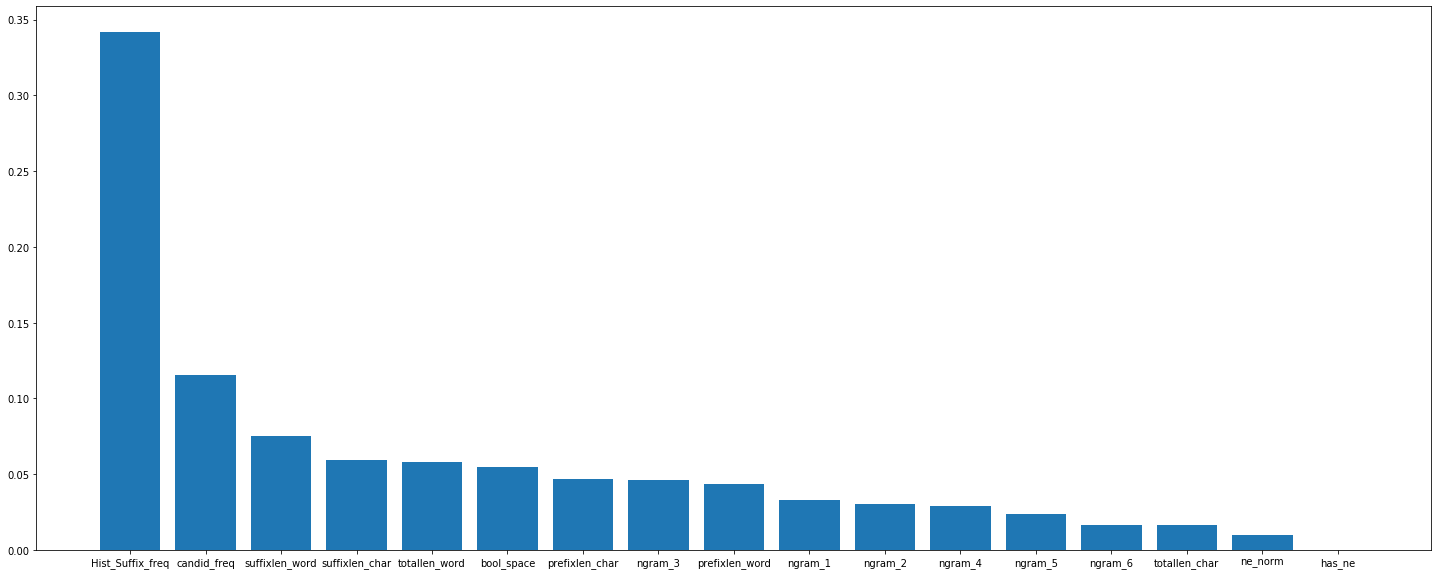

In [72]:
imp = list(feature_imp['Importance'])
var = list(feature_imp['Variable'])

fig, ax = plt.subplots(1, 1, figsize = (25, 10))
plt.bar(var, imp)
plt.show()

# Setup lambda boosting

In [3]:
(x_train, y_train, qid_train, x_test, y_test, qid_test,
 x_valid, y_valid, qid_valid) = load_svmlight_files(
    ("evaldata.txt", "testdata.txt", "evaldata.txt"), 
    query_id=True, zero_based=True)

# instantiate the matrices
dtrain = xgboost.DMatrix(x_train, y_train)
dvalid = xgboost.DMatrix(x_valid, y_valid)
dtest = xgboost.DMatrix(x_test, y_test)

# set the group counts from the query IDs
dtrain.set_group([len(list(items)) for _key, items in itertools.groupby(qid_train)])
dtest.set_group([len(list(items)) for _key, items in itertools.groupby(qid_test)])
dvalid.set_group([len(list(items)) for _key, items in itertools.groupby(qid_valid)])

# save the query IDs for testing
qid_train = qid_train
qid_test = qid_test
qid_valid = qid_valid

params = {'booster': 'gbtree', 'tree_method': 'hist', 'gpu_id': -1, 'predictor': 'cpu_predictor'}

# Train the dataset

In [6]:
# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]

num_trees=2500
check_metric_improvement_rounds=10

# aucpr: under the precision vs recall curve

evals_result = {}
params['objective'] = 'rank:pairwise'
params['eval_metric'] = ['ndcg', 'map', 'aucpr']
bstc = xgboost.train(params, dtrain, num_boost_round=num_trees,
                     early_stopping_rounds=check_metric_improvement_rounds,
                     evals=watchlist, evals_result=evals_result)

[0]	eval-ndcg:0.93880	eval-map:0.91925	eval-aucpr:0.59565	train-ndcg:0.94188	train-map:0.92315	train-aucpr:0.60228
Multiple eval metrics have been passed: 'train-aucpr' will be used for early stopping.

Will train until train-aucpr hasn't improved in 10 rounds.
[1]	eval-ndcg:0.93851	eval-map:0.91883	eval-aucpr:0.60603	train-ndcg:0.94220	train-map:0.92359	train-aucpr:0.61660
[2]	eval-ndcg:0.93712	eval-map:0.91701	eval-aucpr:0.62695	train-ndcg:0.94119	train-map:0.92224	train-aucpr:0.64442
[3]	eval-ndcg:0.93783	eval-map:0.91797	eval-aucpr:0.63849	train-ndcg:0.94185	train-map:0.92312	train-aucpr:0.65837
[4]	eval-ndcg:0.93773	eval-map:0.91785	eval-aucpr:0.64320	train-ndcg:0.94217	train-map:0.92360	train-aucpr:0.66564
[5]	eval-ndcg:0.93704	eval-map:0.91693	eval-aucpr:0.64407	train-ndcg:0.94211	train-map:0.92352	train-aucpr:0.66980
[6]	eval-ndcg:0.93747	eval-map:0.91750	eval-aucpr:0.64763	train-ndcg:0.94215	train-map:0.92358	train-aucpr:0.67289
[7]	eval-ndcg:0.93790	eval-map:0.91802	eval-aucp

In [7]:
print(evals_result['train']['map'][-1])
print(evals_result['train']['ndcg'][-1])
print(evals_result['train']['aucpr'][-1])

0.94178
0.956138
0.791181
